In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from pathlib import Path
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Chargement du dataset et exploration de sa structure

In [2]:
DATA_PATH = Path("../input/h-and-m-personalized-fashion-recommendations")
articles = pd.read_csv(DATA_PATH / "articles.csv")
transactions = pd.read_csv(DATA_PATH / "transactions_train.csv")

## Dataset Articles

Le jeu de données **Articles** regroupe toutes les informations liées aux produits vendus dans les magasins H&M.

In [3]:
print("Shape du DataFrame Articles :", articles.shape)
articles.head()

Shape du DataFrame Articles : (105542, 25)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


***Description des features du dataset Articles***

Identifiant unique d’un article :
* ```article_id``` 

5 colonnes liées au produit:
* ```product_code```– code du produit
* ```prod_name``` - nom du produit
* ```product_type_no``` - numéro du type de produit
* ```product_type_name``` – nom du type de produit, équivalent de product_type_no
* ```product_group_name``` – nom du groupe de produits

2 colonnes liées au motif (pattern):
* ```graphical_appearance_no``` – code du motif
* ```graphical_appearance_name``` – nom du motif

2 colonnes liées à la couleur :
* ```colour_group_code``` – code de la couleur
* ```colour_group_name``` – nom de la couleur

4 colonnes liées à la couleur perçue (ton général) :
* ```perceived_colour_value_id``` – identifiant de la couleur perçue
* ```perceived_colour_value_name``` – nom de la couleur perçue
* ```perceived_colour_master_id``` – identifiant principal de la couleur perçue
* ```perceived_colour_master_name``` – nom principal de la couleur perçue

2 colonnes liées au département:
* ```department_no``` – numéro du département
* ```department_name``` – nom du département

4 colonnes liées à l’index (top-level category):
* ```index_code``` – code de l’index
* ```index_name``` – nom de l’index
* ```index_group_no``` – code du groupe d’index
* ```index_group_name``` – nom du groupe d’index

2 colonnes liées à la section :
* ```section_no``` – numéro de la section
* ```section_name``` – nom de la section

2 colonnes liées au groupe de vêtements :
* ```garment_group_n``` – numéro du groupe de vêtements
* ```garment_group_name``` – nom du groupe de vêtements

1 colonne contenant une description détaillée de l’article :
* ```detail_desc``` – description détaillée de l’article


In [4]:
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

***Gestion des valeurs manquantes***

In [5]:
articles = articles.drop(columns=['detail_desc'])

***Gestion des redondances***

In [6]:
cols_to_drop = [
    'product_code',
    'product_type_no',
    'graphical_appearance_no',
    'colour_group_code',
    'perceived_colour_value_id',
    'perceived_colour_master_id',
    'department_no',
    'index_group_no',
    'section_no',
    'garment_group_no'
]

df= articles.drop(columns=cols_to_drop)

In [7]:
#Verification de l'unicite de l'ID d'article
df['article_id'].duplicated().sum()

np.int64(0)

In [8]:
# Verification des lignes identiques à 100 %
df.duplicated().sum()

np.int64(0)

In [9]:
df_final = df[[
    'article_id',
    'product_type_name',
    'product_group_name',
    'graphical_appearance_name',
    'colour_group_name',
    'perceived_colour_value_name',
    'perceived_colour_master_name',
    'department_name',
    'index_name',
    'index_group_name',
    'section_name',
    'garment_group_name'
]]

In [10]:
# Features initiales 
features = [c for c in df_final.columns ]

print("Features:", features)

Features: ['article_id', 'product_type_name', 'product_group_name', 'graphical_appearance_name', 'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'department_name', 'index_name', 'index_group_name', 'section_name', 'garment_group_name']


***Encodage des features categorielles***

In [12]:
summary = pd.DataFrame({
    'nb_valeurs_uniques': df_final.select_dtypes(include='object').nunique(),
    'nb_valeurs_manquantes': df_final.select_dtypes(include='object').isnull().sum()
})

summary


,nb_valeurs_uniques,nb_valeurs_manquantes
product_type_name,131,0
product_group_name,19,0
graphical_appearance_name,30,0
colour_group_name,50,0
perceived_colour_value_name,8,0
perceived_colour_master_name,20,0
department_name,250,0
index_name,10,0
index_group_name,5,0
section_name,56,0


In [13]:
df_final = df_final.copy()

for col in df_final.columns:
    if col !='article_id':
        le = LabelEncoder()
        df_final[col] = le.fit_transform(
            df_final[col].astype(str)
        )

df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype
---  ------                        --------------   -----
 0   article_id                    105542 non-null  int64
 1   product_type_name             105542 non-null  int64
 2   product_group_name            105542 non-null  int64
 3   graphical_appearance_name     105542 non-null  int64
 4   colour_group_name             105542 non-null  int64
 5   perceived_colour_value_name   105542 non-null  int64
 6   perceived_colour_master_name  105542 non-null  int64
 7   department_name               105542 non-null  int64
 8   index_name                    105542 non-null  int64
 9   index_group_name              105542 non-null  int64
 10  section_name                  105542 non-null  int64
 11  garment_group_name            105542 non-null  int64
dtypes: int64(12)
memory usage: 9.7 MB


## Dataset Transactions

Le jeu de données **Transactions** contient des informations sur le nombre de transaction de chaque article.

In [14]:
print("Shape du DataFrame Transactions :", transactions.shape)
transactions.head()

Shape du DataFrame Transactions : (31788324, 5)


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


***Description des features du dataset Articles***
* ```t_dat``` -date de la transaction au format YYYY-MM-DD
* ```customer_id``` - identifiant du client
* ```article_id``` - identifiant du produit
* ```price``` - prix de produit
* ```sales_channel_id``` - canal de vente

In [15]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ GB


In [16]:
#Vérifier les valeurs manquantes
transactions.isnull().sum()

t_dat               0
customer_id         0
article_id          0
price               0
sales_channel_id    0
dtype: int64

In [17]:
#Vérifier les doublons
transactions.duplicated().sum()
transactions = transactions.drop_duplicates()

In [18]:
#Convertir t_dat en datetime
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])
begin = transactions['t_dat'].min()
end = transactions['t_dat'].max()
print('Date range is from {} to {}.'.format(begin.date(), end.date()))

Date range is from 2018-09-20 to 2020-09-22.


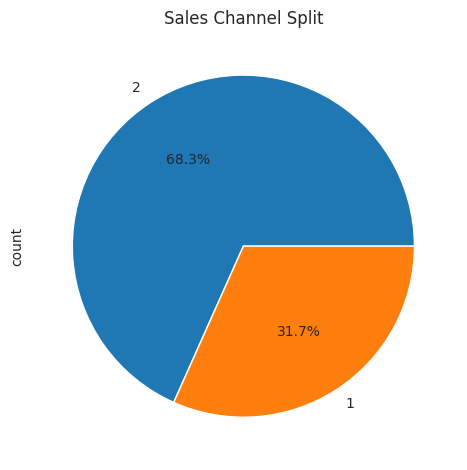

In [45]:
#Répartition des canaux de vente
transactions['sales_channel_id'].value_counts().plot(kind='pie', autopct='%1.1f%%', 
                            title='Sales Channel Split')    
plt.tight_layout()
plt.show()

## Feature Engeneering

### Statistiques de prix

L'objectif est de capturer les caractéristiques de prix de chaque article qui peuvent influencer les recommandations

In [20]:
df_features = df_final.copy()
price_stats = transactions.groupby('article_id')['price'].agg(['mean', 'max', 'std']).reset_index()
price_stats.columns = ['article_id', 'price_mean', 'price_max', 'price_std']

# Gérer les valeurs manquantes dans price_std (articles avec 1 seule transaction)
price_stats['price_std'] = price_stats['price_std'].fillna(0)

df_features = df_features.merge(price_stats, on='article_id', how='left')

# Optimisation mémoire, Supprimer le dataframe intermédiaire
del price_stats
gc.collect()

5334

### Popularité (90 derniers jours) 

In [21]:
max_date = transactions['t_dat'].max()
recent_trans = transactions[transactions['t_dat'] > (max_date - pd.Timedelta(days=90))]
popularity = recent_trans.groupby('article_id').size().reset_index(name='recent_sales_count')

df_features = df_features.merge(popularity, on='article_id', how='left')

del recent_trans
del popularity
gc.collect()

0

### Identifier le canal de vente (en ligne vs magazin)

In [22]:
channel_stats = transactions.groupby('article_id')['sales_channel_id'].mean().reset_index(name='avg_sales_channel')
df_features = df_features.merge(channel_stats, on='article_id', how='left')

del channel_stats
gc.collect()

# GÉRER LES VALEURS MANQUANTES
df_features['recent_sales_count'] = df_features['recent_sales_count'].fillna(0)
df_features = df_features.fillna(df_features.mean(numeric_only=True))

print(f"Shape du dataframe: {df_features.shape}")

Shape du dataframe: (105542, 17)


### Standarisation

In [23]:
X = df_features.drop(columns=['article_id'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"X Shape: {X_scaled.shape}")

X Shape: (105542, 16)


### PCA (Principal Component Analysis)

Les données haute-dimensionnelle sont difficiles à visualiser et à analyser. PCA réduit la dimensionnalité en gardant la max de la variance

In [24]:
pca = PCA(n_components=0.95,random_state=42)  
X_latent = pca.fit_transform(X_scaled)
print(f"Reduced shape: {X_latent.shape}")

Reduced shape: (105542, 12)


## K-Means – Clustering des Articles

Appliquons l’algorithme **K-Means** afin de regrouper les articles similaires en clusters.


### Mesure de qualité : Silhouette Score

**Silhouette Score** est une métrique de validation qui varie entre -1 et 1 qui permet d’évaluer la qualité du clustering en mesurant à quel point il est bien regroupé avec les éléments de son propre cluster,et bien séparé des autres clusters.

Pour chaque point nous avons:

- **a** : distance moyenne entre ce point et les autres points de son cluster
- **b** : distance moyenne entre ce point et les points du cluster le plus proche

La valeur de la silhouette est donnée par la formule :


$$s = \frac{b - a}{\max(a, b)}$$
Plus le score est proche de 1, plus les clusters sont denses et bien séparés.



In [26]:
def evaluate_kmeans(X, k_values):
    results = {}

    for k in k_values:
        print(f"Testing K-Means (K={k})")

        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        sil = silhouette_score(X, labels)
        results[k] = sil

    results_df = (
        pd.DataFrame.from_dict(results, orient="index", columns=["Silhouette"])
        .sort_values("Silhouette", ascending=False)
    )

    best_k = results_df.index[0]

    print(f"\nBest K selected: {best_k}")

    return results_df, best_k


In [38]:
k_values = [10, 15, 20, 25]

results_df, best_k = evaluate_kmeans(X_latent, k_values)

display(results_df)


STARTING K-MEANS EVALUATION

Testing K-Means (K=10)
Testing K-Means (K=15)
Testing K-Means (K=20)
Testing K-Means (K=25)

Best K selected: 20


,Silhouette
20,0.124939
10,0.124648
15,0.122473
25,0.121955


In [28]:
best_kmeans = KMeans(n_clusters=best_k,random_state=42)
best_kmeans.fit(X_latent)
df_features["cluster"] = best_kmeans.labels_


### Fonction de Recommandation (basée sur le clustering K-Means)


In [43]:
def recommend_kmeans(article_id, df_features, kmeans_model, top_k=5):
 
    try:
        idx = df_features[df_features['article_id'] == article_id].index[0]
        
        cluster_label = kmeans_model.labels_[idx]
        
        cluster_indices = np.where(kmeans_model.labels_ == cluster_label)[0]
        cluster_indices = cluster_indices[cluster_indices != idx]
        
        recommended_ids = df_features.iloc[cluster_indices]['article_id'].values[:top_k]
        return recommended_ids
    
    except IndexError:
        print(f"Error: Article ID {article_id} not found.")
        return []

## KNN (K-Nearest Neighbors) 

### VISUALIZATION

In [ ]:
import matplotlib.image as mpimg

def display_image(article_id, ax=None, title=None):
    """
    Helper function to display an image for a given article ID using matplotlib.
    Handles path structure: 012/0123456789.jpg
    """
    
    
    str_id = str(article_id).zfill(10)
    folder = str_id[:3]
    # Adjust path if running locally vs Kaggle
    #fichiere h&m mndmin f 01 7ta 023 lhad sabab kanakhdou mn path li 3ndou nfss debut bach matloaditch file kamlin
    path = DATA_PATH / f"images/{folder}/{str_id}.jpg"
    
    # Placeholder if not found / error handling
    if not path.exists():
        if ax:
            ax.text(0.5, 0.5, "Image Not Found", ha='center', va='center')
            ax.axis('off')
            if title: ax.set_title(title, fontsize=8)
        return

    try:
        # Use matplotlib's imread directly
        img = mpimg.imread(str(path))
        # ax grid mode active ou non peut etre 2 a 3 sinon pas on a pas default ax
        if ax:
            ax.imshow(img)
            ax.axis('off')
            if title: ax.set_title(title, fontsize=8)
        else:
            plt.imshow(img)
            plt.axis('off')
            if title: plt.title(title)
            plt.show()
    except Exception as e:
        if ax:
            #va and ha for text centering from axis
            ax.text(0.5, 0.5, "Error Loading", ha='center', va='center')
            ax.axis('off')



### Recomenendation using KNN 

This function implements a **k-Nearest Neighbors (k-NN)** approach by calculating the  norm (Euclidean distance) between a target vector  and all vectors  in the latent space .

### Mathematical Logic

The similarity is determined by minimizing the distance function:

$$d(u, v) = \sqrt{\sum_{i=1}^{n} (u_i - v_i)^2}$$

where the top  items with the smallest  values are selected as the most similar recommendations.


PCA est construite pour minimiser l'erreur Euclidienne

La magnitude (longueur) du vecteur porte de l'information structurelle importante (la variance expliquée). Un produit avec une forte magnitude dans l'espace latent a des caractéristiques très "marquées

In [ ]:

from sklearn.metrics.pairwise import euclidean_distances


def recommend_similar_items(article_id, df_features, X_latent, top_k=5):
    """
    (Distance-Based)  best because AE latent space PCA is defined as the orthogonal projection that minimizes Euclidean error.:
    1. Look up the 'Latent Vector' for the input article.
    2. Calculate the distance between this vector and ALL other items.
    3. Return the items with the smallest distance (most similar).
    """
    try:
        # 1. trouver l'index dyal had l'article_id f df_features
        # Note: We assume df_features is aligned with X_latent indices
        idx = df_features[df_features['article_id'] == article_id].index[0]
        
        # 2. rji3 l'vector dyal had l'article (reshape to 1 row)
        source_vector = X_latent[idx].reshape(1, -1)
        
        # 3. Calculate Euclidean Distance to ALL items
        # (This is fast: calculating 1 vs 100k takes milliseconds)
        dists = euclidean_distances(source_vector, X_latent).flatten()
        
        # 4. Get indices of the smallest distances
        # argsort gives us the indices sorted from smallest distance to largest
        # We skip the first one (index 0) because that is the item itself (distance=0)
        closest_indices = dists.argsort()[1:top_k+1]
        
        # 5. Retrieve Article IDs for these indices
        recommended_ids = df_features.iloc[closest_indices]['article_id'].values
        
        return recommended_ids

    except IndexError:
        print(f"Error: Article ID {article_id} not found in processed data.")
        return []

In [ ]:

def recommend_and_visualize(article_id, df_features, X_latent, articles_meta, top_k=5 , kmeans_model=best_kmeans, use_kmeans=False ):
    """
    Visualizes the source item and its recommendations side-by-side.
    Now requires X_latent instead of 'labels'.
    """
    # Call the recommendation function avec distance euclidean logic list
    if use_kmeans :
        recs = recommend_kmeans(article_id, df_features, kmeans_model, top_k)
    else:
        recs = recommend_similar_items(article_id, df_features, X_latent, top_k)
    
    # Early exit if no recommendations
    if len(recs) == 0:
        return

    # Setup Plot
    n_cols = top_k + 1
    fig, axes = plt.subplots(1, n_cols, figsize=(3 * n_cols, 4))
    if n_cols == 1: axes = [axes] # Handle single plot case

    # 1. Plot Source
    try:
        source_info = articles_meta[articles_meta['article_id'] == article_id].iloc[0]
        title_text = f"SOURCE:\n{source_info['prod_name'][:15]}...\n({source_info['product_type_name']})"
        display_image(article_id, axes[0], title=title_text)
    except:
         display_image(article_id, axes[0], title="Source (Metadata Missing)")

    # 2. Plot Recommendations
    for i, rec_id in enumerate(recs):
        try:
            rec_info = articles_meta[articles_meta['article_id'] == rec_id].iloc[0]
            title_text = f"REC #{i+1}:\n{rec_info['prod_name'][:15]}...\n({rec_info['product_type_name']})"
            display_image(rec_id, axes[i+1], title=title_text)
        except IndexError:
            display_image(rec_id, axes[i+1], title=f"REC #{i+1}")

    plt.tight_layout()
    plt.show()


# TEST pipeline

### COMPARAISON : K-Means vs Distance-Based Recommendation

Testing Random Article ID: 743444003

METHOD 1: K-Means Constrained Search
Focus: Finds items within the same semantic cluster.


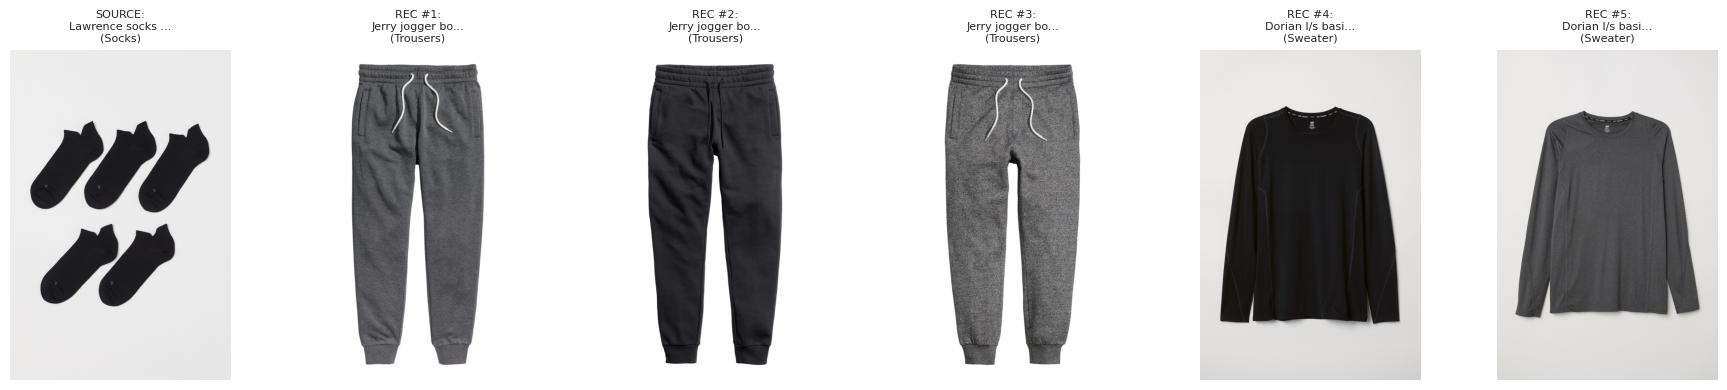


--------------------------------------------------

METHOD 2: Global Euclidean Search (Pure Distance)
Focus: Finds mathematically closest items across the whole dataset.


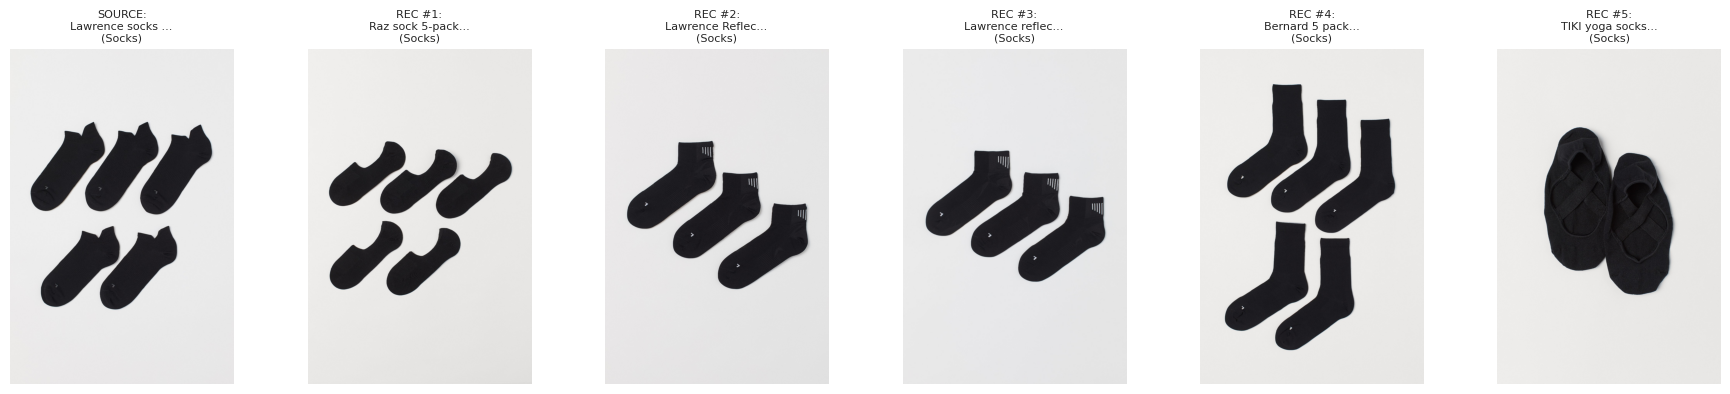

In [36]:
random_id = df_features['article_id'].sample(1).iloc[0]
print(f"Testing Random Article ID: {random_id}")
print("="*50)

# --- COMPARISON 1: CLUSTER-BASED ---
print("\nMETHOD 1: K-Means Constrained Search")
print("Focus: Finds items within the same semantic cluster.")
recommend_and_visualize(random_id, df_features, X_latent, articles, top_k=5, use_kmeans=True)

print("\n" + "-"*50)

# --- COMPARISON 2: PURE DISTANCE ---
print("\nMETHOD 2: Global Euclidean Search (Pure Distance)")
print("Focus: Finds mathematically closest items across the whole dataset.")
recommend_and_visualize(random_id, df_features, X_latent, articles, top_k=5)

# SAVE MODELS

In [ ]:
import joblib  # For saving/loading large NumPy arrays (efficient storage for scaler) CPU optimized
import pickle # For saving/loading complex objects like PCA and KMeans models 
#general-purpose, works for many Python objects, including cuML GPU models.


# 1. Save Scaler 
joblib.dump(scaler, "scaler.joblib")

# sauvergarder le scaler bach n3awdou nst3mlo f production, joblib kay7fdo l'object b format optimisé pour les grands tableaux numpy, 
# c'est plus rapide que pickle pour ce genre d'objets.
# 2. Save PCA (Dimensionality reduction matrix)
with open("best_pca.pkl", "wb") as f:
    pickle.dump(pca, f)


# 3. Save K-Means Model (Centroids and labels)
# Note: cuML KMeans handles pickle for GPU-trained models
with open("best_kmeans.pkl", "wb") as f:
    pickle.dump(best_kmeans, f)

# 4. Save Cluster Mapping (CSV for instant lookup)
# Links Article ID to Cluster ID: f(ID) -> Cluster
df_clusters = df_features[['article_id']].copy()
df_clusters['cluster'] = best_labels
df_clusters.to_csv("article_clusters.csv", index=False)

print("\nAll pipeline files are ready for production.")